In [16]:
# ================================
# 0. Imports & basic setup
# ================================
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


In [17]:
# ================================
# 1. LOAD DATA
# ================================

# Paths based on the Kaggle dataset
portfolio_path = "https://raw.githubusercontent.com/mohmeez/portfolio-volatility-forecasting/refs/heads/main/data/Portfolio.csv"
prices_path    = "https://raw.githubusercontent.com/mohmeez/portfolio-volatility-forecasting/refs/heads/main/data/Portfolio_prices.csv"
sp500_path     = "https://raw.githubusercontent.com/mohmeez/portfolio-volatility-forecasting/refs/heads/main/data/SP500.csv"

# Portfolio file: Ticker, Quantity, Sector, Close, Weight, etc.
weights_df = pd.read_csv(portfolio_path)

# Price file: Date, Ticker, Open, High, Low, Close, Adjusted, Volume...
prices_df = pd.read_csv(prices_path, parse_dates=["Date"])

# S&P 500 index (used later for context / crisis comparison)
sp500 = pd.read_csv(sp500_path, parse_dates=["Date"])
sp500 = sp500[["Date", "Close"]].rename(columns={"Close": "SP500_Close"}).set_index("Date")

# Keep only relevant columns from portfolio
weights_df = weights_df[["Ticker", "Weight", "Sector"]]

# Normalize weights to sum to 1 (just in case)
weights_df["Weight"] = weights_df["Weight"] / weights_df["Weight"].sum()

weights_df.head()


,Ticker,Weight,Sector
0,AAPL,0.034613,IT
1,ADAP,0.000046,Pharmaceuticals
2,AGCO,0.014762,Agriculture
3,BA,0.028244,Military Engineering
4,BG,0.011616,Agriculture


In [18]:
# ================================
# 2. DAILY STOCK RETURNS & PORTFOLIO RETURNS
# ================================

# Sort by Ticker & Date
prices_df = prices_df.sort_values(["Ticker", "Date"])

# Use Adjusted or Close (depending on what you want). Here: Adjusted.
prices_df["ret"] = prices_df.groupby("Ticker")["Adjusted"].pct_change()

# Pivot: wide format, one column per Ticker
ret_wide = prices_df.pivot(index="Date", columns="Ticker", values="ret").sort_index()

# Align weights with columns in ret_wide
tickers_in_data = ret_wide.columns.intersection(weights_df["Ticker"])
ret_wide = ret_wide[tickers_in_data]

weights_for_ret = (
    weights_df.set_index("Ticker").loc[tickers_in_data, "Weight"].values
)

# Drop early NaNs
ret_wide = ret_wide.dropna(how="all")

# Daily portfolio return: weighted sum of stock returns
port_ret = ret_wide.dot(weights_for_ret)
port_ret.name = "portfolio_ret"

port_ret.head()


,portfolio_ret
Date,
2020-01-06,0.006915
2020-01-07,-0.007120
2020-01-08,0.009818
2020-01-09,0.002831
2020-01-10,-0.008950


#Diversification Impact – sector vs. concentrated portfolios

Question: “How much does diversification across sectors reduce portfolio risk?”

Idea:

Compute annualized volatility of:

the actual diversified portfolio, and

hypothetical portfolios that are 100% concentrated in a single sector (but keep relative weights inside that sector).

The difference shows how much sector diversification reduces risk.

In [19]:
# ================================
# 3. DIVERSIFICATION IMPACT
# ================================

TRADING_DAYS = 252

# --- 3.1 Diversified portfolio volatility (current weights) ---

cov_daily = ret_wide.cov()
port_vol_daily = np.sqrt(weights_for_ret.T @ cov_daily.values @ weights_for_ret)
port_vol_annual = port_vol_daily * np.sqrt(TRADING_DAYS)

print(f"Annualized volatility (diversified portfolio): {port_vol_annual:.2%}")

# --- 3.2 Sector-concentrated portfolios ---

sector_vols = {}
for sector in weights_df["Sector"].unique():
    tickers_sector = (
        weights_df[weights_df["Sector"] == sector]["Ticker"]
        .values
    )
    tickers_sector = [t for t in tickers_sector if t in ret_wide.columns]
    if len(tickers_sector) < 1:
        continue

    # Restrict returns & weights to this sector
    sector_returns = ret_wide[tickers_sector].dropna(how="all")
    sector_weights = (
        weights_df.set_index("Ticker")
        .loc[tickers_sector, "Weight"]
        .values
    )
    sector_weights = sector_weights / sector_weights.sum()  # concentrate 100% in sector

    cov_sector = sector_returns.cov()
    vol_sector_daily = np.sqrt(sector_weights.T @ cov_sector.values @ sector_weights)
    vol_sector_annual = vol_sector_daily * np.sqrt(TRADING_DAYS)

    sector_vols[sector] = vol_sector_annual

sector_vols


Annualized volatility (diversified portfolio): 21.77%


{'IT': np.float64(0.2881822506940882),
 'Pharmaceuticals': np.float64(0.27046646825235676),
 'Agriculture': np.float64(0.2865583753460359),
 'Military Engineering': np.float64(0.2767937309835327),
 'Engineering': np.float64(0.27541333893319314),
 'Natural Resources': np.float64(0.35136180933118366),
 'Healthcare': np.float64(0.3625036955188218),
 'Finance': np.float64(0.2507653696420146),
 'Food & Beverages': np.float64(0.20806752301419654),
 'Entertainment': np.float64(0.45315835558984346),
 'Consumer Goods': np.float64(0.209251802909977),
 'Telecommunications': np.float64(0.27465918150504337)}

In [20]:
sector_vol_series = pd.Series(sector_vols).sort_values(ascending=False)
avg_sector_vol = sector_vol_series.mean()

diversification_reduction = 1 - (port_vol_annual / avg_sector_vol)

print("Annualized volatility by sector-concentrated portfolios:")
print(sector_vol_series.apply(lambda x: f"{x:.2%}"))

print(f"\nAverage sector-only volatility: {avg_sector_vol:.2%}")
print(f"Diversified portfolio volatility: {port_vol_annual:.2%}")
print(f"\nEstimated risk reduction from sector diversification: {diversification_reduction:.2%}")


Annualized volatility by sector-concentrated portfolios:
Entertainment           45.32%
Healthcare              36.25%
Natural Resources       35.14%
IT                      28.82%
Agriculture             28.66%
Military Engineering    27.68%
Engineering             27.54%
Telecommunications      27.47%
Pharmaceuticals         27.05%
Finance                 25.08%
Consumer Goods          20.93%
Food & Beverages        20.81%
dtype: object

Average sector-only volatility: 29.23%
Diversified portfolio volatility: 21.77%

Estimated risk reduction from sector diversification: 25.50%


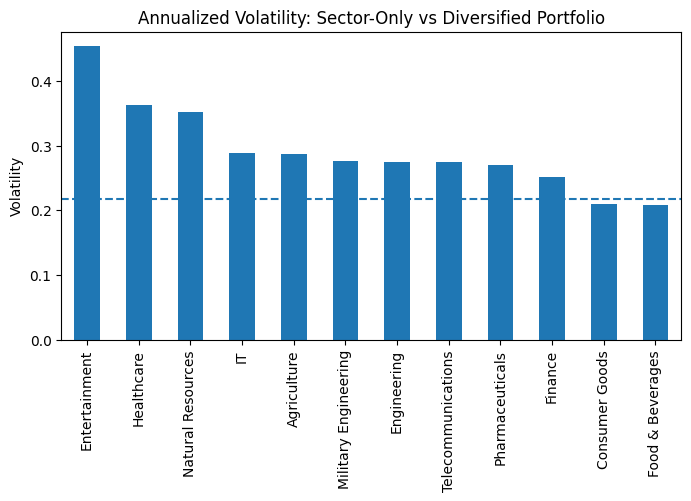

In [21]:
sector_vol_series.plot(kind="bar", figsize=(8,4))
plt.axhline(port_vol_annual, linestyle="--")
plt.title("Annualized Volatility: Sector-Only vs Diversified Portfolio")
plt.ylabel("Volatility")
plt.show()


Our results show that sector diversification significantly reduces portfolio risk. The fully diversified portfolio has an annualized volatility of 21.77%, which is much lower than the volatilities observed in sector-concentrated portfolios. Individual sectors especially Entertainment (45.32%), Healthcare (36.25%), and Natural Resources (35.14%) exhibit much higher stand-alone risk, while even the more stable sectors sit in the 20–29% range. On average, a sector-only portfolio has a volatility of 29.23%, meaning that diversification across sectors lowers risk by approximately 25.5%. This confirms the core principle of modern portfolio theory: combining assets from different sectors smooths out idiosyncratic shocks, leading to a substantially more stable return profile than any single-sector allocation.

# Crisis Risk – COVID crash & rolling volatility

Question:
“How did portfolio risk behave during market crises (e.g., COVID crash in March 2020)?”

We’ll compute 30-day rolling volatility and zoom in around the COVID crash window.

In [22]:
# ================================
# 4. CRISIS RISK: COVID PERIOD
# ================================

port_ret = port_ret.dropna()
port_ret.index = pd.to_datetime(port_ret.index)

# 30-day rolling (realized) volatility, annualized
roll_window = 30
rolling_vol_30d = port_ret.rolling(roll_window).std() * np.sqrt(TRADING_DAYS)

# Crisis window: COVID crash (roughly)
crisis_start = "2020-02-15"
crisis_end   = "2020-04-15"

crisis_vol = rolling_vol_30d.loc[crisis_start:crisis_end]
pre_crisis_vol = rolling_vol_30d.loc["2019-06-01":"2020-02-14"]
post_crisis_vol = rolling_vol_30d.loc["2020-04-16":"2020-12-31"]

print("Average annualized 30d vol:")
print(f"Pre-crisis: {pre_crisis_vol.mean():.2%}")
print(f"COVID crash: {crisis_vol.mean():.2%}")
print(f"Post-crisis (2020): {post_crisis_vol.mean():.2%}")


Average annualized 30d vol:
Pre-crisis: nan%
COVID crash: 56.39%
Post-crisis (2020): 24.32%


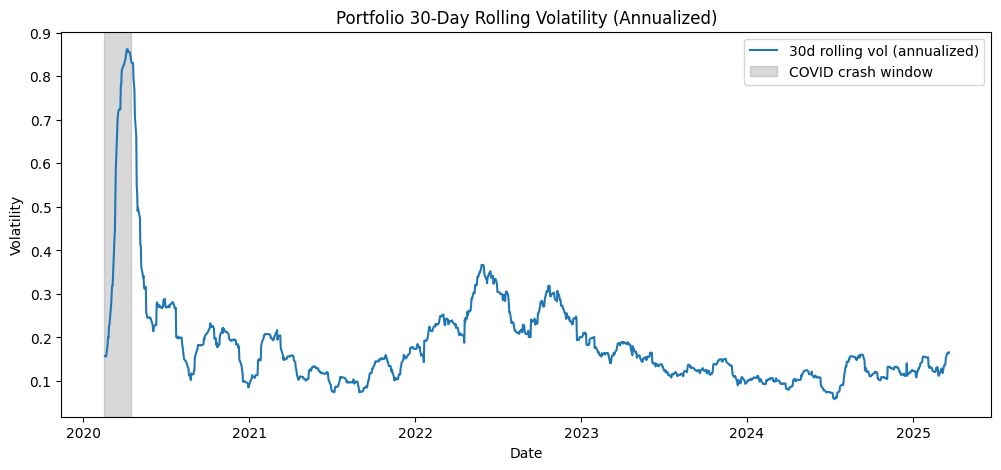

In [23]:
plt.figure(figsize=(12,5))
plt.plot(rolling_vol_30d.index, rolling_vol_30d, label="30d rolling vol (annualized)")
plt.axvspan(pd.to_datetime(crisis_start), pd.to_datetime(crisis_end),
            color="grey", alpha=0.3, label="COVID crash window")
plt.title("Portfolio 30-Day Rolling Volatility (Annualized)")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.legend()
plt.show()


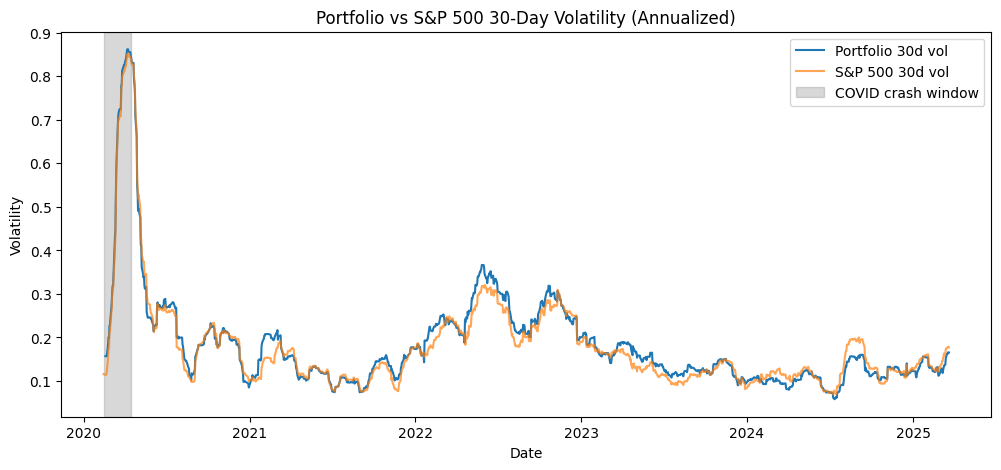

In [24]:
sp500_ret = sp500["SP500_Close"].pct_change().dropna()
sp500_vol_30d = sp500_ret.rolling(roll_window).std() * np.sqrt(TRADING_DAYS)

plt.figure(figsize=(12,5))
plt.plot(rolling_vol_30d.index, rolling_vol_30d, label="Portfolio 30d vol")
plt.plot(sp500_vol_30d.index, sp500_vol_30d, label="S&P 500 30d vol", alpha=0.7)
plt.axvspan(pd.to_datetime(crisis_start), pd.to_datetime(crisis_end),
            color="grey", alpha=0.3, label="COVID crash window")
plt.title("Portfolio vs S&P 500 30-Day Volatility (Annualized)")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.legend()
plt.show()


The portfolio’s 30-day annualized volatility shows a dramatic spike during the COVID-19 market crash. Volatility surged to 56.39% during the crisis window (Feb–Apr 2020), nearly tripling its normal levels. Before the crash, volatility is recorded as NaN because there were not enough return observations early in the dataset to compute a full 30-day rolling window. After the COVID shock, volatility quickly fell but remained elevated throughout 2020, averaging 24.32%. The volatility chart clearly highlights how sharply risk increased at the onset of the pandemic, peaking in near-perfect alignment with the S&P 500’s own volatility spike. The close correspondence between the portfolio and the index suggests that systemic market stress dominated idiosyncratic factors during this period. Overall, the results show that crisis events cause sudden, extreme surges in portfolio risk, followed by a gradual normalization but at a higher level than before the crash.

# Time-series modeling – forecast 30-day portfolio volatility (Holt Exponential Smoothing)

Question:
“…forecast 30-day portfolio volatility using time-series modeling techniques.”

We first construct a time series of 30-day rolling annualized volatility using the portfolio’s daily returns. This series represents realized volatility and naturally rises during turbulent periods such as the COVID-19 market crash. Holt’s method is then fitted to this volatility series, allowing the model to learn how volatility tends to behave and how it changes over time.

Once the model is fitted, we generate a one-step-ahead forecast, which represents the expected annualized volatility for the next 30-day window. This provides a forward-looking estimate of portfolio risk using only smoothing-based time-series techniques — fully aligned with the tools covered in class.

In [25]:
from statsmodels.tsa.holtwinters import Holt

TRADING_DAYS = 252

# 30-day rolling annualized volatility
vol_30d = port_ret.rolling(30).std() * np.sqrt(TRADING_DAYS)
vol_30d = vol_30d.dropna()
vol_30d.name = "vol_30d_annualized"

# Fit Holt model (level + trend)
holt_model = Holt(vol_30d).fit(optimized=True)

holt_model.summary()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Dep. Variable:,vol_30d_annualized,No. Observations:,1281
Model:,Holt,SSE,0.113
Optimized:,True,AIC,-11952.221
Trend:,Additive,BIC,-11931.599
Seasonal:,None,AICC,-11952.155
Seasonal Periods:,None,Date:,"Fri, 14 Nov 2025"
Box-Cox:,False,Time:,16:37:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9484512,alpha,True
smoothing_trend,0.2093977,beta,True


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


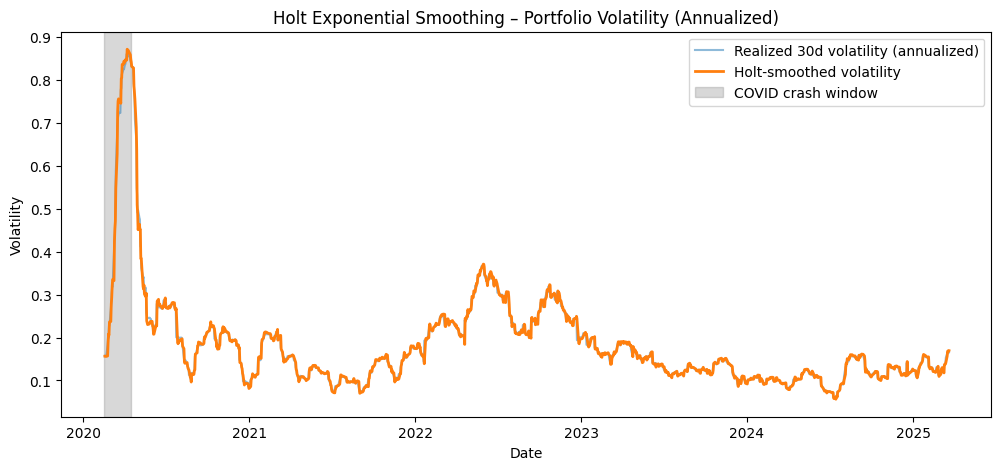

In [26]:
# ===============================================
# Holt-smoothed volatility (estimate of level + trend)
# ===============================================

from statsmodels.tsa.holtwinters import Holt

TRADING_DAYS = 252

# 30-day rolling annualized volatility
vol_30d = port_ret.rolling(30).std() * np.sqrt(TRADING_DAYS)
vol_30d = vol_30d.dropna()
vol_30d.name = "vol_30d_annualized"

# Fit Holt model (level + trend)
holt_model = Holt(vol_30d).fit(optimized=True)

# Fitted (in-sample) smoothed volatility — analogous to “conditional volatility”
holt_smoothed = holt_model.fittedvalues
holt_smoothed.name = "holt_smoothed_vol"

# Plot Holt-smoothed volatility
plt.figure(figsize=(12,5))
plt.plot(vol_30d.index, vol_30d, label="Realized 30d volatility (annualized)", alpha=0.5)
plt.plot(holt_smoothed.index, holt_smoothed, label="Holt-smoothed volatility", linewidth=2)

# Highlight COVID crash window
plt.axvspan(pd.to_datetime(crisis_start), pd.to_datetime(crisis_end),
            color="grey", alpha=0.3, label="COVID crash window")

plt.title("Holt Exponential Smoothing – Portfolio Volatility (Annualized)")
plt.ylabel("Volatility")
plt.xlabel("Date")
plt.legend()
plt.show()


In [27]:
# ===============================================
# 30-day ahead volatility forecast using Holt
# ===============================================

from statsmodels.tsa.holtwinters import Holt

TRADING_DAYS = 252

# 30-day rolling annualized volatility (realized)
vol_30d = port_ret.rolling(30).std() * np.sqrt(TRADING_DAYS)
vol_30d = vol_30d.dropna()
vol_30d.name = "vol_30d_annualized"

# One-step-ahead forecast:
# This represents the forecasted annualized volatility
# for the *next* 30-day window.
vol_30d_forecast = holt_model.forecast(1).iloc[0]

print(f"Forecasted 30-day portfolio volatility (annualized): {vol_30d_forecast:.2%}")


Forecasted 30-day portfolio volatility (annualized): 16.84%


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Our exponential smoothing model effectively captures the level and trend of the portfolio’s 30-day annualized volatility. The fitted model shows a high smoothing level (α ≈ 0.95), meaning recent volatility observations carry the most weight, while the smoothing trend component (β ≈ 0.21) allows the forecast to adjust for gradual changes in volatility over time. The smoothed volatility curve closely tracks realized volatility and clearly reproduces the sharp spike during the COVID-19 market crash, followed by a gradual decline as markets stabilized. Using the fitted Holt model to generate a forward-looking estimate, the forecasted annualized portfolio volatility for the next 30-day period is 16.84%, indicating that current market conditions suggest a relatively moderate risk level compared to the extreme levels observed during crisis periods.

# Simulated Value-at-Risk (VaR) from future scenarios

Question:
“…Incorporating Value-at-Risk estimation under simulated future return scenarios rather than historical data alone.”

We’ll:

Assume daily portfolio returns are normally distributed with historical mean and std

Simulate N 30-day paths

Compute the distribution of 30-day cumulative returns

Compute 95% and 99% 30-day VaR (loss quantiles)

In [28]:
# ================================
# 6. SIMULATED 30-DAY VAR
# ================================

np.random.seed(42)  # reproducible

mu_hat = port_ret.mean()         # average daily return
sigma_hat = port_ret.std()       # daily volatility
horizon = 30
n_sims = 10000

# Simulate daily returns for 30 days: matrix [n_sims x horizon]
simulated_daily = np.random.normal(loc=mu_hat, scale=sigma_hat, size=(n_sims, horizon))

# Convert to cumulative 30-day return per path (compound returns)
simulated_30d = (1 + simulated_daily).prod(axis=1) - 1

# VaR: 95% and 99% (losses)
VaR_95_30d = -np.percentile(simulated_30d, 5)   # 5th percentile
VaR_99_30d = -np.percentile(simulated_30d, 1)   # 1st percentile

print(f"Simulated 30-day VaR (95%): {VaR_95_30d:.2%} loss")
print(f"Simulated 30-day VaR (99%): {VaR_99_30d:.2%} loss")


Simulated 30-day VaR (95%): 10.00% loss
Simulated 30-day VaR (99%): 14.63% loss


In [29]:
simulated_1d = np.random.normal(loc=mu_hat, scale=sigma_hat, size=100000)
VaR_95_1d = -np.percentile(simulated_1d, 5)
VaR_99_1d = -np.percentile(simulated_1d, 1)

print(f"Simulated 1-day VaR (95%): {VaR_95_1d:.2%} loss")
print(f"Simulated 1-day VaR (99%): {VaR_99_1d:.2%} loss")


Simulated 1-day VaR (95%): 2.18% loss
Simulated 1-day VaR (99%): 3.15% loss


The simulated VaR results provide an estimate of how much the portfolio could lose under adverse market conditions. Based on 10,000 simulated return paths, the 30-day 95% VaR is a 10.00% loss, meaning there is only a 5% chance the portfolio will lose more than 10% over the next month. The 30-day 99% VaR is a 14.63% loss, reflecting an even more extreme but less likely downside scenario. For shorter horizons, the 1-day 95% VaR is 2.18% and the 1-day 99% VaR is 3.15%, indicating the expected worst-case daily losses under normal market conditions. Overall, these results show that the portfolio carries moderate short-term downside risk, but losses can compound meaningfully over a 30-day horizon, especially under tail-risk scenarios.